<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Pneumonia_classification_fastai_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2

In [59]:
# Import necessary libraries
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings('ignore')

In [4]:
!unzip -qq "/content/drive/MyDrive/AV_Hack/pneumonia_dataset.zip" -d "/content/drive/MyDrive/AV_Hack/"

In [5]:
# Set path to your root directory
path = Path('/content/drive/MyDrive/AV_Hack/pneumonia_dataset')
path.ls()

[PosixPath('/content/drive/MyDrive/AV_Hack/pneumonia_dataset/sample_submission.csv'),
 PosixPath('/content/drive/MyDrive/AV_Hack/pneumonia_dataset/test'),
 PosixPath('/content/drive/MyDrive/AV_Hack/pneumonia_dataset/test.csv'),
 PosixPath('/content/drive/MyDrive/AV_Hack/pneumonia_dataset/train')]

In [6]:
# We are creating a fastai DataBunch from our dataset
# The transformers are already built into the model
data = ImageDataBunch.from_folder(path, train='train', 
                                  valid_pct=0.2, 
                                  test="test",
                                  ds_tfms=get_transforms(do_flip=False), 
                                  size=224, 
                                  bs=64, 
                                  num_workers=4)

['normal', 'pneumonia'] 2
1940 485


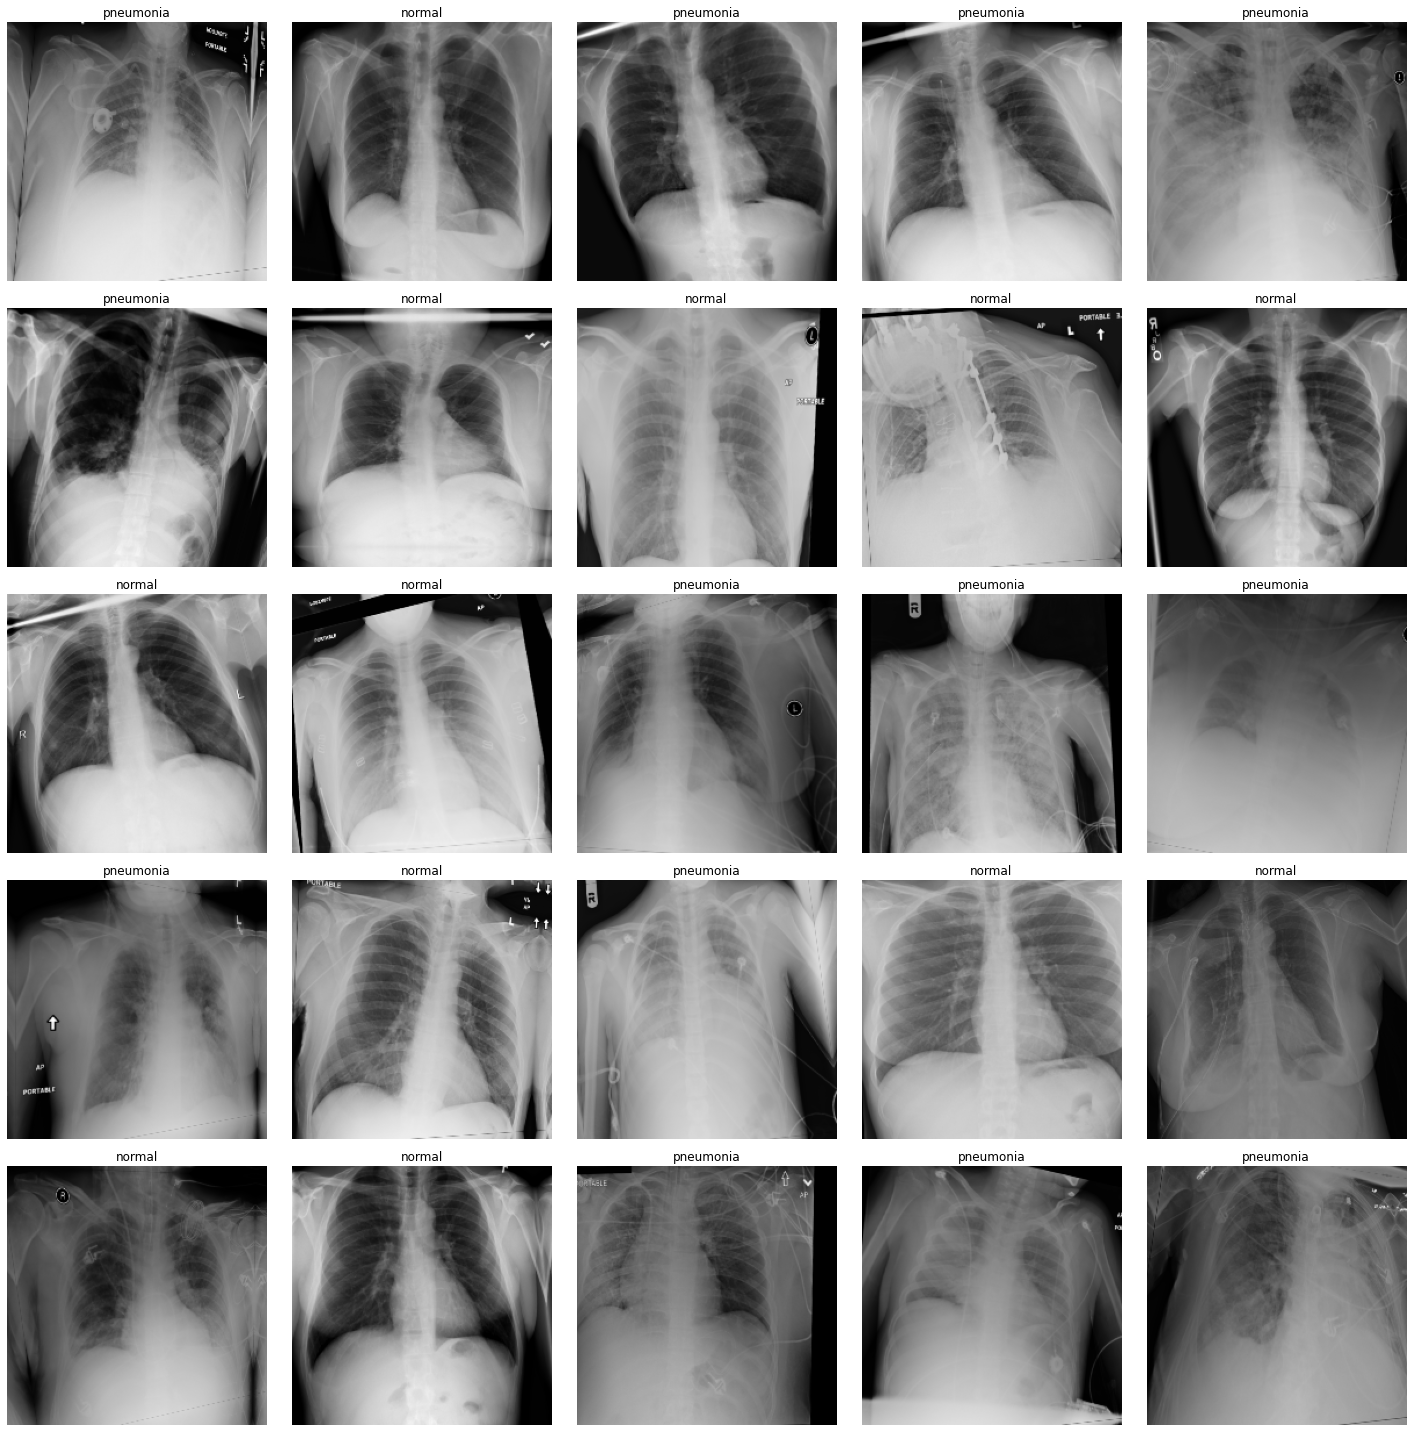

In [7]:
# Show what the data looks like after being transformed
data.show_batch()
# See the classes and count of classes in your dataset
print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

In [48]:
f1score = FBeta(average='weighted',beta=1.0)

In [65]:
# Build the CNN model with the pretrained resnet34
learn = cnn_learner(data, models.densenet121, metrics = [error_rate,accuracy,f1score])

In [50]:
# Train the model on 4 epochs of data at the default learning rate
# Ignore error rate/valid loss data here, decreasing train loss is all that matters
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.169968,1.367354,0.521649,0.438184,01:18
1,1.044448,0.751973,0.608247,0.602242,01:16
2,0.863758,0.671089,0.647423,0.646240,01:17
3,0.729967,0.645475,0.682474,0.682750,01:16
4,0.653476,0.640481,0.688660,0.688697,01:17


In [51]:
# Save the model
learn.save('densenet121-1')

# Load the Model
learn.load('densenet121-1')

Learner(data=ImageDataBunch;

Train: LabelList (1940 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: /content/drive/MyDrive/AV_Hack/pneumonia_dataset;

Valid: LabelList (485 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,normal,normal
Path: /content/drive/MyDrive/AV_Hack/pneumonia_dataset;

Test: LabelList (606 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/AV_Hack/pneumonia_dataset, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [52]:
# Build a Classification Interpretation object from our learn model
interp = ClassificationInterpretation.from_learner(learn)

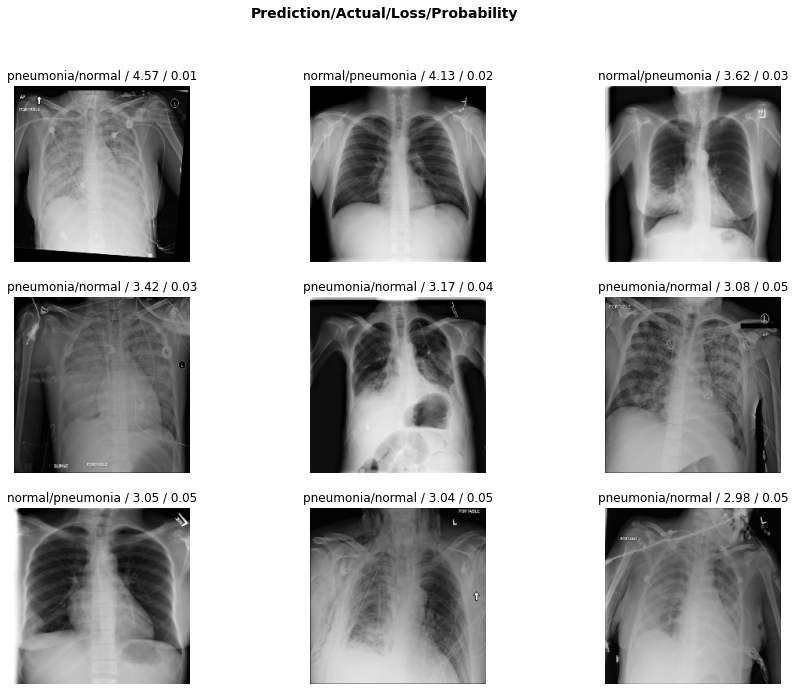

In [53]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

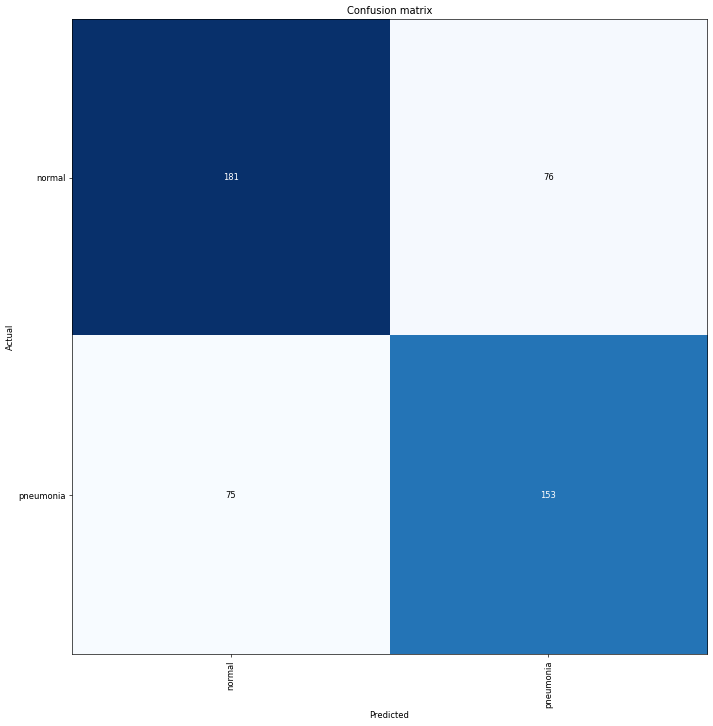

In [54]:
# Build a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [55]:
# Build a text version of a confusion matrix-- really helpful with a lot of classes
interp.most_confused(min_val=2)

[('normal', 'pneumonia', 76), ('pneumonia', 'normal', 75)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 7.59E-06


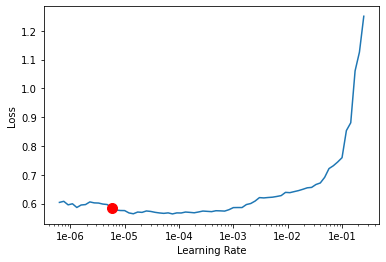

In [56]:
# Unfreeze all layers of the CNN
learn.unfreeze()

# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [57]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, max_lr=slice(6e-5, 6e-4))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.586830,0.704054,0.676289,0.675297,01:18
1,0.571272,0.638426,0.686598,0.686635,01:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.92E-05


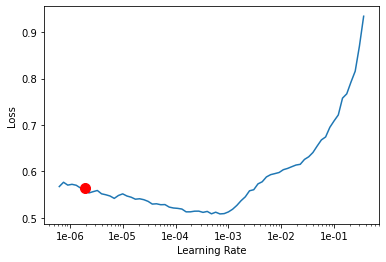

In [21]:
# See if optimal learning rate changes
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.505534,0.660369,0.701031,0.698387,01:18
1,0.526808,0.747633,0.659794,0.644960,01:18
2,0.509151,0.649797,0.709278,0.709159,01:18
3,0.455013,0.636981,0.701031,0.701244,01:19
4,0.387798,0.618947,0.717526,0.717670,01:18


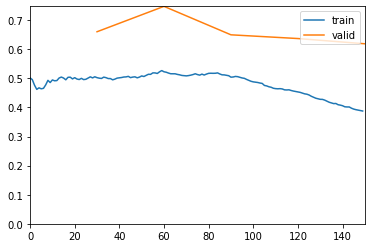

In [60]:
# Fit the model 2 more epochs over all the layers
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3),
                    callbacks=[SaveModelCallback(learn,monitor="error_rate",mode="min",name="dense121"),
                               ShowGraph(learn),EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
])

In [61]:
# Save the model
learn.save('stage-2')

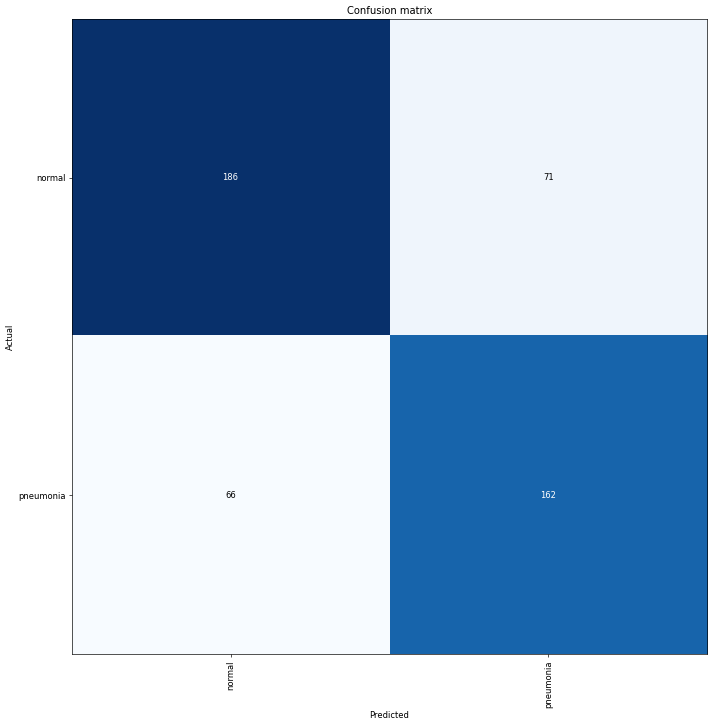

In [62]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [63]:
# Build a text version of a confusion matrix-- really helpful with a lot of classes
interp.most_confused(min_val=2)

[('normal', 'pneumonia', 71), ('pneumonia', 'normal', 66)]

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.338833,1.082464,0.465979,0.534021,0.483749,01:18
1,1.245343,0.883301,0.412371,0.587629,0.579020,01:18
2,1.194972,0.741391,0.350515,0.649485,0.649485,01:18
3,1.161175,0.761074,0.338144,0.661856,0.662055,01:18
4,1.066512,0.758051,0.334021,0.665979,0.666122,01:17
5,1.025051,0.764445,0.340206,0.659794,0.659968,01:17


Better model found at epoch 0 with error_rate value: 0.46597936749458313.


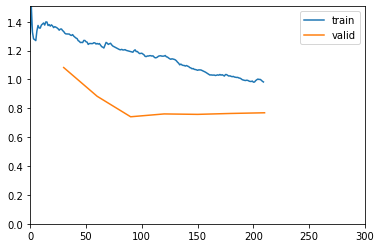

Better model found at epoch 1 with error_rate value: 0.41237112879753113.
Better model found at epoch 2 with error_rate value: 0.3505154550075531.
Better model found at epoch 3 with error_rate value: 0.33814433217048645.
Better model found at epoch 4 with error_rate value: 0.33402061462402344.
Epoch 6: early stopping


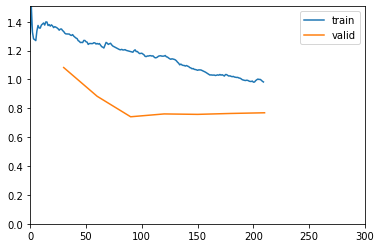

In [66]:
# Fit the model 2 more epochs over all the layers
learn.fit_one_cycle(10, max_lr=1e-4,
                    callbacks=[SaveModelCallback(learn,monitor="error_rate",mode="min",name="dense121"),
                               ShowGraph(learn),
                               EarlyStoppingCallback(learn, min_delta=1e-5, patience=3)
                               ,
])

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.985508,0.749772,0.346392,0.653608,0.653413,01:18
1,0.957576,0.746961,0.342268,0.657732,0.657539,01:19
2,0.974304,0.748428,0.331959,0.668041,0.667800,01:18
3,0.969981,0.751840,0.334021,0.665979,0.666218,01:18
4,0.965369,0.755561,0.336082,0.663918,0.664175,01:20
5,0.961216,0.759485,0.350515,0.649485,0.649735,01:18
6,0.976718,0.751581,0.336082,0.663918,0.664175,01:19
7,0.960371,0.758373,0.342268,0.657732,0.657732,01:18
8,0.950505,0.752655,0.329897,0.670103,0.670297,01:19
9,0.952510,0.754637,0.334021,0.665979,0.665557,01:18


Better model found at epoch 0 with error_rate value: 0.3463917672634125.


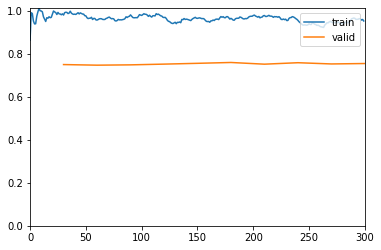

Better model found at epoch 1 with error_rate value: 0.34226804971694946.
Better model found at epoch 2 with error_rate value: 0.3319587707519531.
Better model found at epoch 8 with error_rate value: 0.3298968970775604.


In [68]:
# Fit the model 2 more epochs over all the layers
learn.fit_one_cycle(10, max_lr=5e-6,
                    callbacks=[SaveModelCallback(learn,monitor="error_rate",mode="min",name="dense121"),
                               ShowGraph(learn),
                               EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
])

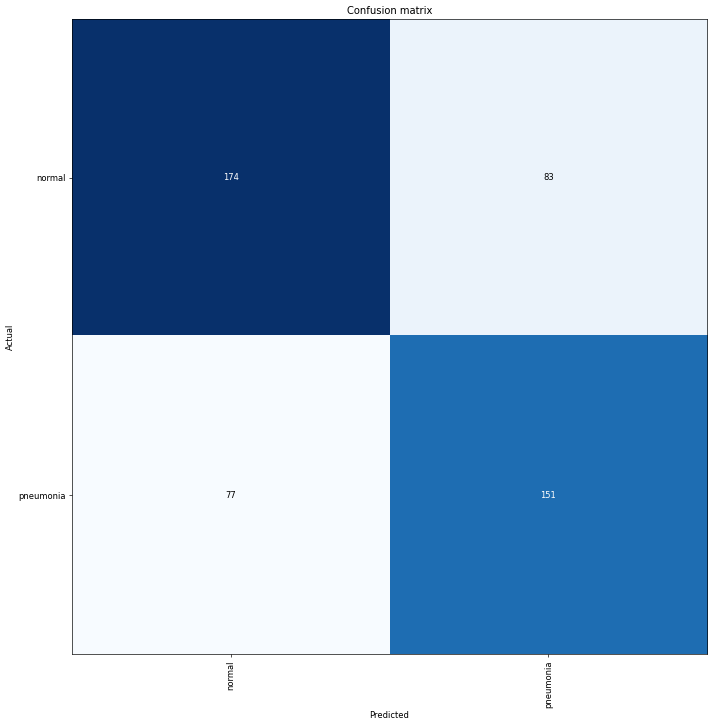

In [70]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.985780,0.744542,0.342268,0.657732,0.657732,01:19
1,0.990041,0.766235,0.327835,0.672165,0.671237,01:19
2,0.944301,0.817560,0.327835,0.672165,0.667061,01:19
3,0.913805,0.745431,0.331959,0.668041,0.667102,01:19


Better model found at epoch 0 with error_rate value: 0.34226804971694946.


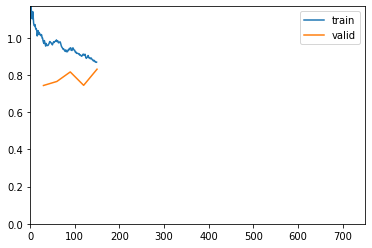

Better model found at epoch 1 with error_rate value: 0.3278350532054901.
Better model found at epoch 4 with error_rate value: 0.31134021282196045.
Epoch 4: early stopping


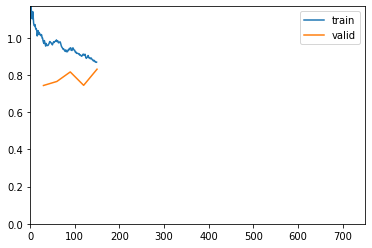

In [71]:
# Fit the model 2 more epochs over all the layers
learn.fit_one_cycle(25, max_lr=1e-3,
                    callbacks=[SaveModelCallback(learn,monitor="error_rate",mode="min",name="dense121"),
                               ShowGraph(learn),
                               EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.51E-06


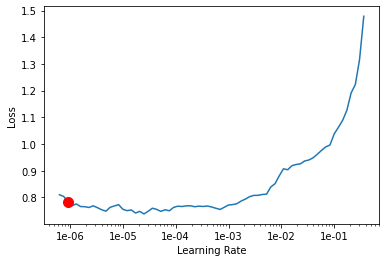

In [72]:
# Unfreeze all layers of the CNN
learn.unfreeze()

# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.718557,0.823374,0.323711,0.676289,0.676156,01:20
1,0.742990,0.831019,0.321649,0.678351,0.677943,01:19
2,0.751946,0.821188,0.323711,0.676289,0.676156,01:19
3,0.766355,0.818601,0.317526,0.682474,0.682547,01:18
4,0.743277,0.813945,0.319588,0.680412,0.680519,01:19
5,0.763109,0.798621,0.317526,0.682474,0.682072,01:18
6,0.750549,0.800445,0.307216,0.692784,0.692453,01:19
7,0.742036,0.799085,0.315464,0.684536,0.683942,01:19
8,0.747537,0.789042,0.311340,0.688660,0.688434,01:19
9,0.747749,0.770660,0.313402,0.686598,0.686075,01:19


Better model found at epoch 0 with error_rate value: 0.3237113356590271.


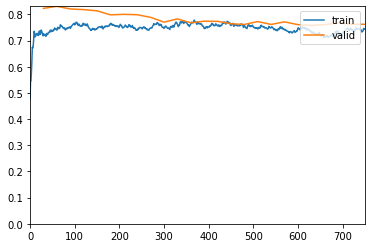

Better model found at epoch 1 with error_rate value: 0.3216494917869568.
Better model found at epoch 3 with error_rate value: 0.3175257742404938.
Better model found at epoch 6 with error_rate value: 0.30721649527549744.
Better model found at epoch 13 with error_rate value: 0.3051546514034271.
Better model found at epoch 16 with error_rate value: 0.3010309338569641.
Epoch 24: early stopping


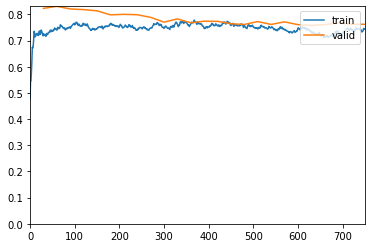

In [73]:
# Fit the model 2 more epochs over all the layers
learn.fit_one_cycle(25, max_lr=1e-6,
                    callbacks=[SaveModelCallback(learn,monitor="error_rate",mode="min",name="dense121"),
                               ShowGraph(learn),
                               EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
])

In [74]:
preds, target = learn.TTA()

In [75]:
predictions = np.argmax(preds,axis=1)


In [32]:
predictions

tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,

In [29]:
target

tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [76]:
from sklearn.metrics import *
accuracy_score(target,predictions)

0.6804123711340206

In [77]:
f1_score(target,predictions)

0.6695095948827293

In [37]:
preds, target = learn.TTA(ds_type=DatasetType.Test)

In [40]:
label = np.argmax(preds,axis=1)

In [41]:
sub = pd.read_csv("/content/drive/MyDrive/AV_Hack/pneumonia_dataset/test.csv")
sub.head()

,filename
0,CXR_test_519.png
1,CXR_test_578.png
2,CXR_test_359.png
3,CXR_test_573.png
4,CXR_test_471.png


In [42]:
sub['label'] = label

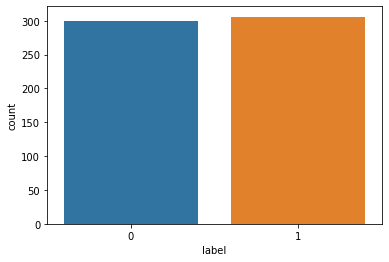

In [43]:
import seaborn as sns
sns.countplot(x='label',data=sub)

In [44]:
data.classes

['normal', 'pneumonia']

In [45]:
sub['label'] = sub['label'].apply(lambda x:data.classes[x] )

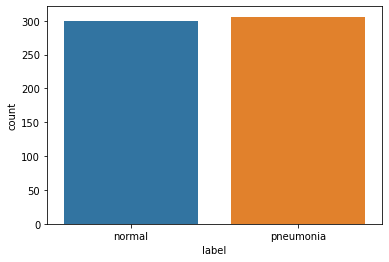

In [46]:
import seaborn as sns
sns.countplot(x='label',data=sub)

In [47]:
sub.to_csv("submission_resnet34.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_resnet34.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Resnet34 -Submission successful! Your score is 55.296465667600934.**